# Final Project Fast CNN

In [1]:
import torch
cuda_enable = True
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [2]:
import os
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from pycocotools.coco import COCO
from torchvision import datasets, transforms, models

In [3]:
!git clone https://github.com/Chang-Chia-Chi/Pedestrian.git
!git clone https://github.com/Chang-Chia-Chi/Final-Project.git

Cloning into 'Pedestrian'...
remote: Enumerating objects: 708, done.
remote: Total 708 (delta 0), reused 0 (delta 0), pack-reused 708
Receiving objects: 100% (708/708), 58.01 MiB | 49.09 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Cloning into 'Final-Project'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [4]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):
    # image ID
    img_id = self.ids[idx]
    # image file_name
    img_file = self.coco.loadImgs(img_id)[0]["file_name"]
    # read_imgae
    img = Image.open(os.path.join(self.root, img_file))
    # get annotation ID
    ann_ids = self.coco.getAnnIds(imgIds = img_id)
    # read annotation
    anns = self.coco.loadAnns(ann_ids)
    # num of people in the picture
    num_objs = len(anns)
    # build information about bounding box & area
    boxes = []
    areas = []
    for i in range(num_objs):
      x_min = anns[i]['bbox'][0]
      y_min = anns[i]['bbox'][1]
      x_max = x_min + anns[i]['bbox'][2]
      y_max = y_min + anns[i]['bbox'][3]
      boxes.append([x_min, y_min, x_max, y_max])
      areas.append(anns[i]['area'])
  
    # transfer information to Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    img_id = torch.tensor([img_id])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Annotation in dict form
    Annotations = {
        "boxes" : boxes,
        "labels" : labels,
        "image_id" : img_id,
        "area" : areas,
        "iscrowd" : iscrowd
    }

    # transforms
    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, Annotations
  
  def __len__(self):
    return len(self.ids)

In [5]:
def get_transforms(train):
  trans = []
  if train:
    trans.append(transforms.RandomHorizontalFlip(0.5))
    # trans.append(transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)))
    # trans.append(transforms.ColorJitter(brightness=1, contrast=1, saturation=1))
  trans.append(transforms.ToTensor())
  return transforms.Compose(trans)

train_data_path = '/content/Pedestrian/PNGImages'
coco_path = '/content/Pedestrian/Json/train.json'
train_dataset = ImageDataset(root=train_data_path, annotation=coco_path, transforms=get_transforms(train=True))

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, 2, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# change question to binary classification (human, not human)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

epochs = 12
model = model.to(device)

for _ in range(epochs):
  model.train()
  i = 0
  for imgs, annotations in train_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k:v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print("Iteration: {}; Loss: {}".format(i, losses))
  lr_scheduler.step()

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Iteration: 1; Loss: 2.4302008152008057
Iteration: 2; Loss: 1.2702571153640747
Iteration: 3; Loss: 0.5771080255508423
Iteration: 4; Loss: 0.44867372512817383
Iteration: 5; Loss: 1.0613863468170166
Iteration: 6; Loss: 1.3408397436141968
Iteration: 7; Loss: 0.6742390394210815
Iteration: 8; Loss: 0.5181353092193604
Iteration: 9; Loss: 0.36828622221946716
Iteration: 10; Loss: 1.4125099182128906
Iteration: 11; Loss: 0.638192892074585
Iteration: 12; Loss: 0.6967419385910034
Iteration: 13; Loss: 0.40097686648368835
Iteration: 14; Loss: 1.988511562347412
Iteration: 15; Loss: 0.7556656002998352
Iteration: 16; Loss: 1.437825322151184
Iteration: 17; Loss: 0.6114627718925476
Iteration: 18; Loss: 1.000766634941101
Iteration: 19; Loss: 0.921770453453064
Iteration: 20; Loss: 0.4911543130874634
Iteration: 21; Loss: 0.24217137694358826
Iteration: 22; Loss: 0.6630628705024719
Iteration: 23; Loss: 0.2950296401977539
Iteration: 24; Loss: 0.809877872467041
Iteration: 25; Loss: 0.2240944802761078
Iteration: 

In [9]:
def im_convert(tensor):
    image = tensor.clone().detach().cpu().numpy()
    
    # [C, W, H] --> [W, H, C]
    image = image.transpose(1, 2, 0)

    # denormalize
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))

    # 將 image 的最大最小值設定為 [0, 1] 超過 1 則設為 1 / 小於 0 則設為 0
    image = image.clip(0, 1)
    
    return image

[{'boxes': tensor([[1.7863e+03, 2.0022e+03, 2.0610e+03, 2.7040e+03],
        [2.6828e+03, 1.9217e+03, 2.9956e+03, 2.7071e+03],
        [2.4191e+03, 1.9127e+03, 2.7404e+03, 2.7217e+03],
        [2.1287e+03, 1.9809e+03, 2.3679e+03, 2.5981e+03],
        [6.6221e+02, 1.8969e+03, 1.0826e+03, 2.9823e+03],
        [1.4185e+03, 1.9880e+03, 1.6981e+03, 2.6970e+03],
        [9.5784e+02, 1.9907e+03, 1.3513e+03, 2.9589e+03],
        [4.6431e+02, 1.9665e+03, 6.6768e+02, 2.4799e+03],
        [2.3348e+03, 1.9956e+03, 2.5175e+03, 2.5021e+03],
        [1.7771e+02, 2.0503e+03, 5.4731e+02, 2.9575e+03],
        [3.0463e+03, 1.9670e+03, 3.2688e+03, 2.5234e+03],
        [2.5777e+03, 1.9255e+03, 2.8339e+03, 2.6377e+03],
        [3.1225e+03, 1.9246e+03, 3.5650e+03, 3.0000e+03],
        [8.4943e+02, 1.9402e+03, 1.2154e+03, 2.9393e+03],
        [2.8836e+03, 2.0122e+03, 3.0718e+03, 2.5037e+03],
        [2.2080e+03, 1.9947e+03, 2.4002e+03, 2.5052e+03],
        [1.0414e+02, 1.9942e+03, 3.7768e+02, 2.7557e+03],
   

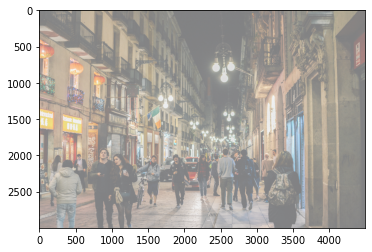

In [10]:
import cv2
from google.colab.patches import cv2_imshow

# use 10.pic to illustrate performance for a single picture.
img = cv2.imread("/content/Final-Project/10.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# transfer array to pillow format
val_tran = get_transforms(train=False)
im_pil = Image.fromarray(img)
im_pil = val_tran(im_pil)
plt.imshow(im_convert(im_pil))

image = im_pil.to(device)
model_val = model.eval()
output = model([image])
print(output)

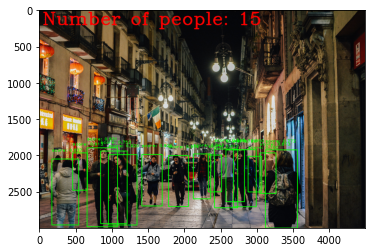

True

In [11]:
scores = output[0]['scores'].detach().cpu().numpy()
num_people = len(scores[scores > 0.7])

boxes = output[0]['boxes'].detach().cpu().numpy()
boxes = boxes[:num_people]

for i in range(num_people):
  img = cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), (0, 255, 0), thickness=10)
  img = cv2.putText(img, "score: {:.3f}".format(scores[i]), (boxes[i][0], int(boxes[i][1] - 100)),
                    cv2.FONT_HERSHEY_PLAIN, 4, (0, 255, 0), thickness=5)

img = cv2.putText(img,"Number of people: {}".format(num_people), (50, 200),
                  cv2.FONT_HERSHEY_COMPLEX, 8, (255, 0, 0), thickness=15)

plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output.jpg', img)

In [ ]:
cap = cv2.VideoCapture("/content/Final-Project/final.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter('output.avi', fourcc, 30.0, (1920, 1080))
i = 1
while cap.isOpened():
  print(i)
  ret, frame = cap.read()
  if ret:
    if i < 152:
      out.write(frame)
      i += 1
      continue
    elif i > 451 and i < 512:
      out.write(frame)
      i += 1
      continue     
    elif i > 748 and i < 809:
      out.write(frame)
      i += 1
      continue   
    elif i > 1078 and i < 1139:
      out.write(frame)
      i += 1
      continue   
    elif i > 1378 and i < 1439:
      out.write(frame)
      i += 1
      continue   
    elif i > 1661 and i < 1722:
      out.write(frame)
      i += 1
      continue   
    else:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      val_tran = get_transforms(train=False)
      im_pil = Image.fromarray(frame)
      im_pil = val_tran(im_pil)

      image = im_pil.to(device)
      model_val = model.eval()
      output = model([image])
      scores = output[0]['scores'].detach().cpu().numpy()
      num_people = len(scores[scores > 0.6])

      boxes = output[0]['boxes'].detach().cpu().numpy()
      boxes = boxes[:num_people]

      for j in range(num_people):
        frame = cv2.rectangle(frame, (boxes[j][0], boxes[j][1]), (boxes[j][2], boxes[j][3]), (0, 255, 0), thickness=10)
        frame = cv2.putText(frame, "score: {:.3f}".format(scores[j]), (boxes[j][0], int(boxes[j][1] - 50)),
                          cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), thickness=5)

      frame = cv2.putText(frame,"Number of people: {}".format(num_people), (50, 100),
                        cv2.FONT_HERSHEY_COMPLEX, 5, (255, 0, 0), thickness=15)
      
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(frame)
      i += 1 

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
  if i > 2021 :
    cap.release()
    cv2.destroyAllWindows()
    break